<html>
<div>
  <img src="https://www.engineersgarage.com/wp-content/uploads/2021/11/TCH36-01-scaled.jpg" width=360px width=auto style="vertical-align: middle;">
  <span style="font-family: Georgia; font-size:30px; color: white;"> <br/> University of Tehran <br/> AI_CA6_P2 <br/> Spring 02 </span>
</div>
<span style="font-family: Georgia; font-size:15pt; color: white; vertical-align: middle;"> low_mist - std id: 810100186 </span>
</html>

In this notebook we are implement and train a Convolutional Neural Network to classify images.

## Problem Description
in this problem we will learn more about `Neural Network` and specially about `CNN` (i.e. Convolutional Neural Network). for Part. 1 we train a model for a dataset and classify them. Then we learn about unbalanced datasets, and we use data augmentation techniques to improve the performance of our model. At the end we learn about regularization techniques and how to use them to improve the performance of our model.

In [1]:
from __future__ import annotations

# data manipulation
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from abc import ABC, abstractmethod
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import plotly.express as px

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
)
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# types
from dataclasses import dataclass
from enum import Enum
from typing import Union, Iterable, Callable, Optional
from collections import namedtuple, Counter

# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Activation,
    Input,
    Flatten,
    BatchNormalization,
)
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

## torch
import torch
from torch import nn, optim
from torch.nn import ReLU, Sigmoid, Linear
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import grad

# utils
import os
from tqdm import tqdm
import difflib
import urllib.request
import tarfile
import random
import warnings

### Part 0. Preprocessing the dataset.
In this notebook we will train our CNN on CIFAR-10 dataset. The CIFAR-10 dataset is a collection of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is designed for image classification tasks, where the goal is to assign a label to each image indicating which of the 10 classes it belongs to. The classes are mutually exclusive and correspond to common objects in our daily life such as airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

The dataset is divided into two sets: a training set and a test set. The training set contains 50,000 images, while the test set contains 10,000 images. The images in the training set are used to train machine learning models, while the images in the test set are used to evaluate the performance of the models.

The CIFAR-10 dataset is widely used in the machine learning community as a benchmark for evaluating the performance of image classification algorithms. Many state-of-the-art models have been trained on this dataset, and it has become a standard benchmark for comparing the performance of different models.

In addition to the original CIFAR-10 dataset, there are also several variations of the dataset that have been created over the years. For example, there is a CIFAR-100 dataset that contains 100 classes of objects, and there is a CIFAR-10.1 dataset that is designed to be more challenging than the original CIFAR-10 dataset.

In [ ]:
# url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# filepath = "./cifar-10-python.tar.gz"

# if os.path.exists(filepath):
#     os.remove(filepath)

# urllib.request.urlretrieve(url, filepath)

# with tarfile.open(filepath, 'r:gz') as tar:
#     tar.extractall()

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)

170498071/170498071 [==============================] - 3s 0us/step


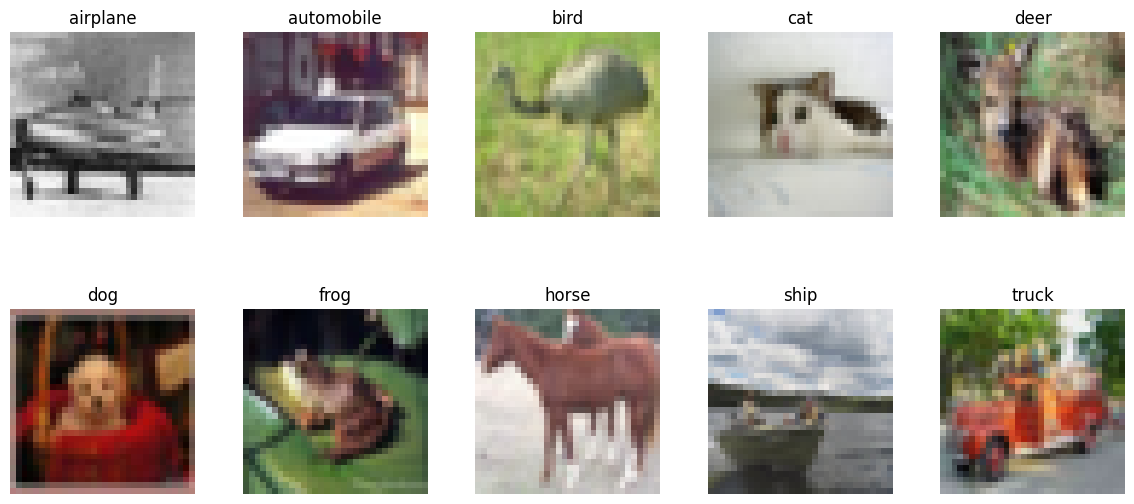

In [3]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

class_images = {}
for i in range(len(class_names)):
    index = random.randint(0, len(x_train) - 1)
    while y_train[index][0] != i:
        index = random.randint(0, len(x_train) - 1)
    class_images[class_names[i]] = x_train[index]

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()
for i in range(len(class_names)):
    axs[i].imshow(class_images[class_names[i]], cmap=plt.cm.binary)
    axs[i].set_title(class_names[i])
    axs[i].axis("off")
plt.show()

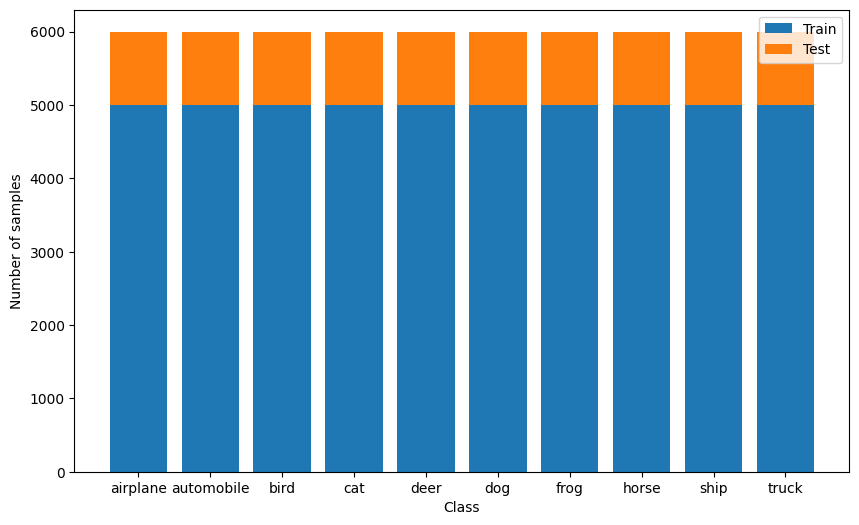

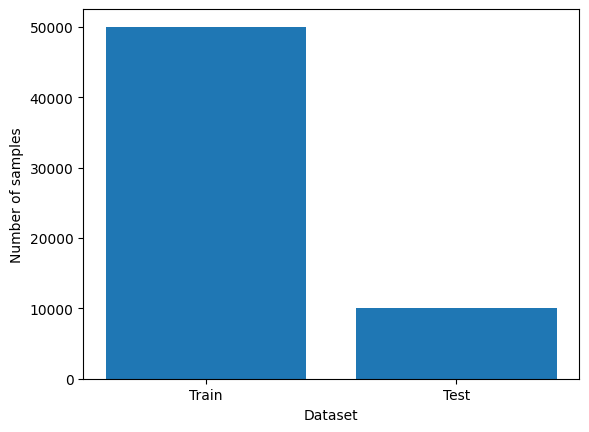

In [4]:
train_counts = [0 for _ in range(len(class_names))]
test_counts = [0 for _ in range(len(class_names))]

for label in y_train:
    train_counts[int(label)] += 1

for label in y_test:
    test_counts[int(label)] += 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(class_names, train_counts, label="Train")
ax.bar(class_names, test_counts, bottom=train_counts, label="Test")
ax.set_ylabel("Number of samples")
ax.set_xlabel("Class")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.bar(["Train", "Test"], [len(x_train), len(x_test)])
ax.set_ylabel("Number of samples")
ax.set_xlabel("Dataset")
plt.show()

Now we `Normalize` pictures and use `OneHot encoding` to encode the labels.  
`Normalization` is a common preprocessing step in machine learning that involves scaling the input data to have zero mean and unit variance. Normalizing the input data can help improve the performance of machine learning models by making the optimization process more efficient and reducing the impact of differences in the scale of the input features.  
`OneHot encoding` is a technique used to represent categorical data as numerical data. In machine learning, many algorithms require numerical input data, and one-hot encoding is a way to convert categorical data into a numerical format that can be used as input to these algorithms.

In one-hot encoding, each category is represented as a binary vector of length equal to the number of categories. The vector has a value of 1 in the position corresponding to the category and 0 in all other positions. For example, suppose we have a categorical variable "color" with three categories: red, green, and blue. We can represent these categories using one-hot encoding as follows:

| Color | One-hot encoding |
|-------|------------------|
| Red   |     [1, 0, 0]    |
| Green |     [0, 1, 0]    |
| Blue  |     [0, 0, 1]    |

One-hot encoding is useful because it allows us to represent categorical data in a way that is compatible with many machine learning algorithms. For example, we can use one-hot encoding to represent categorical variables in a neural network by treating the binary vectors as input features. One-hot encoding also ensures that the numerical representation of the categories does not imply any ordering or hierarchy between the categories, which is important for many applications.

However, one-hot encoding can lead to high-dimensional input data, especially if there are many categories. In some cases, it may be more efficient to use other encoding techniques, such as `label encoding` or `binary encoding`, which can represent categorical data using fewer dimensions. We used this method when we loaded.

Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


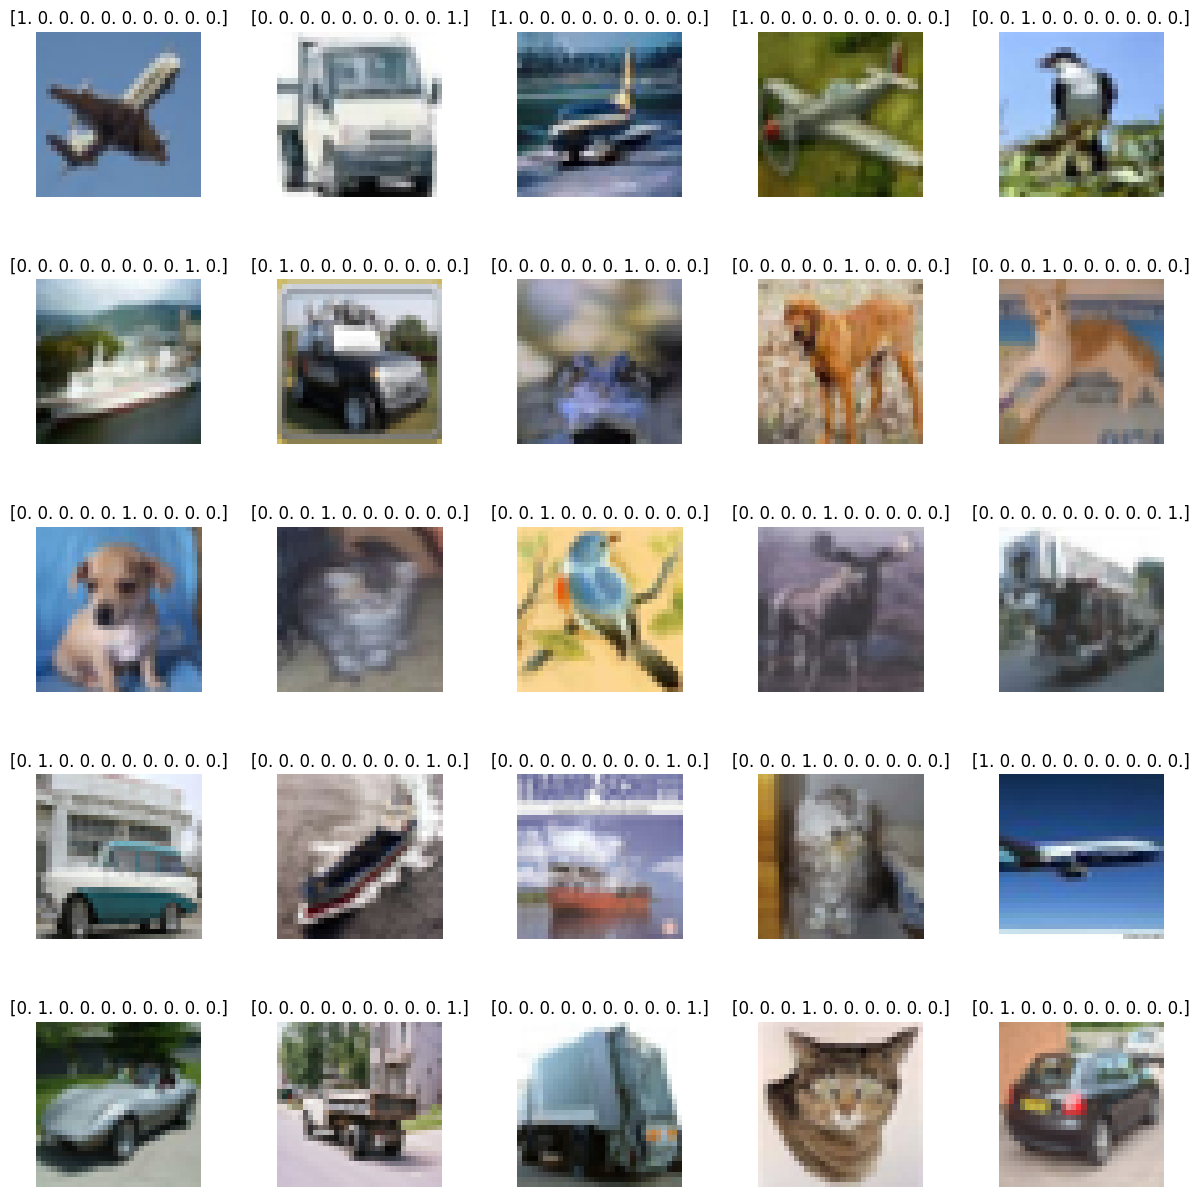

In [6]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, 25):
    index = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[index])
    axes[i].set_title(y_train_onehot[index])
    axes[i].axis("off")

plt.subplots_adjust(hspace=0.5)

### Part 1. Classification Using a CNN
`Convolutional Neural Network (CNN)`   
A CNN is a type of neural network that is commonly used for image classification, object detection, and other computer vision tasks. CNNs are designed to automatically learn features from images, making them well-suited for tasks that involve extracting information from visual data.

A CNN consists of several layers, each of which performs a specific operation on the input data. The most common layers in a CNN are:

1. Convolutional layer: This layer applies a set of filters to the input image to extract features. Each filter is a small matrix of weights that is convolved with the input image to produce a feature map. The filters are learned during training, allowing the network to automatically learn the most important features for the task at hand.

2. Pooling layer: This layer downsamples the feature maps produced by the convolutional layer, reducing the spatial dimensions of the data and making the network more computationally efficient. The most common type of pooling is max pooling, which takes the maximum value in each pooling region.

3. Activation layer: This layer applies a non-linear activation function to the output of the previous layer, allowing the network to learn complex, non-linear relationships between the input and output.

4. Fully connected layer: This layer connects every neuron in the previous layer to every neuron in the current layer, allowing the network to learn complex, high-level representations of the input data.

The architecture of a CNN typically consists of several convolutional and pooling layers followed by one or more fully connected layers. The output of the final layer is a probability distribution over the possible classes, which can be used to make predictions about the input image.

Training a CNN involves optimizing the weights of the network to minimize a loss function, which measures the difference between the predicted output and the true output. This is typically done using backpropagation, which computes the gradient of the loss function with respect to the weights and uses this gradient to update the weights using an optimization algorithm such as Adam.  

![CNN layers](https://emilemathieu.fr/images/blog/cnn/cnn.png)

---

`Adam`  
Adam (Adaptive Moment Estimation) is an optimization algorithm used in deep learning to update the weights of a neural network during training. It is a popular optimization algorithm because it is computationally efficient and requires little memory, making it well-suited for large datasets and complex models.

Adam is an extension of the stochastic gradient descent (SGD) optimization algorithm, which updates the weights of a neural network by computing the gradient of the loss function with respect to the weights and adjusting the weights in the direction of the negative gradient. Adam improves upon SGD by incorporating two additional techniques: momentum and adaptive learning rates.

The momentum technique helps to accelerate the optimization process by adding a fraction of the previous weight update to the current weight update. This helps to smooth out the weight updates and prevent the optimization process from getting stuck in local minima.

The adaptive learning rate technique adjusts the learning rate for each weight based on the magnitude of the gradient and the history of the weight updates. This helps to prevent the optimization process from overshooting the minimum and oscillating around it.

The Adam algorithm combines these two techniques by computing an exponentially decaying average of the past gradients and past squared gradients, and using these averages to adjust the learning rate and momentum parameters. The algorithm also includes bias correction terms to account for the fact that the moving averages are initialized to zero.

Here's the high-level overview of the Adam algorithm:

1. Initialize the weight parameters and the first and second moment estimates to zero.
2. Compute the gradient of the loss function with respect to the weights.
3. Update the first and second moment estimates using the gradient.
4. Compute the bias-corrected first and second moment estimates.
5. Update the weights using the bias-corrected first and second moment estimates and the learning rate and momentum parameters.

The Adam algorithm has several hyperparameters that can be tuned to improve its performance, including the learning rate, momentum parameter, and decay rates for the first and second moment estimates.

---

`Adam vs SGD`  
Adam (Adaptive Moment Estimation) and SGD (Stochastic Gradient Descent) are both optimization algorithms used in deep learning to update the weights of a neural network during training. However, they differ in several ways:

1. Adaptive learning rates: Adam uses adaptive learning rates for each weight based on the magnitude of the gradient and the history of the weight updates, while SGD uses a fixed learning rate for all weights. This allows Adam to adjust the learning rate for each weight based on its importance, which can improve the optimization process.

2. Momentum: Adam incorporates momentum into the weight updates, which helps to smooth out the weight updates and prevent the optimization process from getting stuck in local minima. SGD can also use momentum, but it is not a default feature and must be explicitly specified.

3. Memory requirements: Adam requires more memory than SGD because it needs to store the first and second moment estimates for each weight. This can be a concern for large models or datasets.

4. Convergence speed: Adam can converge faster than SGD because it uses adaptive learning rates and momentum to accelerate the optimization process. However, this is not always the case and depends on the specific problem and model.

5. Robustness to noise: Adam is more robust to noisy gradients than SGD because it uses the second moment estimate to adjust the learning rate, which can help to smooth out the effects of noise. SGD can be more sensitive to noise because it uses a fixed learning rate for all weights.

In summary,  they differ in their use of adaptive learning rates, momentum, memory requirements, convergence speed, and robustness to noise. The choice of algorithm depends on the specific problem and model, and it is often a good idea to experiment with both algorithms to see which one works best.

In [ ]:
def create_cnn_model(
    activation_for_conv: str = "relu", max_pooling_size: tuple[int, int] = (2, 2)
):
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
    cnn.add(Activation(activation_for_conv))
    cnn.add(Conv2D(32, (3, 3)))
    cnn.add(Activation(activation_for_conv))
    cnn.add(MaxPooling2D(pool_size=max_pooling_size))

    cnn.add(Conv2D(64, (3, 3), padding="same"))
    cnn.add(Activation(activation_for_conv))
    cnn.add(Conv2D(64, (3, 3)))
    cnn.add(Activation(activation_for_conv))
    cnn.add(MaxPooling2D(pool_size=max_pooling_size))

    cnn.add(Flatten())
    cnn.add(Dense(512))
    cnn.add(Activation(activation_for_conv))
    cnn.add(Dense(10))
    cnn.add(Activation("softmax"))
    cnn.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )

    return cnn

In [ ]:
cnn = create_cnn_model()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                        

In [7]:
def fit_cnn_model_with_metrics(
    model: Sequential,
    x_train,
    y_train_onehot,
    x_test,
    y_test_onehot,
    batch_size=32,
    epochs=10,
):
    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
    for epoch in range(epochs):
        log = model.fit(
            x_train,
            y_train_onehot,
            batch_size=batch_size,
            epochs=1,
            validation_data=(x_test, y_test_onehot),
            # callbacks=[LearningRateScheduler(lr_schedule)],
        )
        history["loss"].append(log.history["loss"][0])
        history["accuracy"].append(log.history["accuracy"][0])
        history["val_loss"].append(log.history["val_loss"][0])
        history["val_accuracy"].append(log.history["val_accuracy"][0])
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)
        train_report = classification_report(
            y_train_onehot.argmax(axis=1), y_pred_train.argmax(axis=1)
        )
        test_report = classification_report(
            y_test_onehot.argmax(axis=1), y_pred_test.argmax(axis=1)
        )
        print("Train report:\n", train_report)
        print("Test report:\n", test_report)
    plt.plot(history["loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.plot(history["accuracy"], label="train_accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
 

313/313 [==============================] - 1s 2ms/step
Train report:
               precision    recall  f1-score   support

           0       0.76      0.61      0.68      5000
           1       0.80      0.81      0.81      5000
           2       0.62      0.43      0.51      5000
           3       0.50      0.36      0.42      5000
           4       0.62      0.57      0.59      5000
           5       0.45      0.74      0.56      5000
           6       0.78      0.67      0.72      5000
           7       0.70      0.74      0.72      5000
           8       0.69      0.86      0.76      5000
           9       0.75      0.80      0.77      5000

    accuracy                           0.66     50000
   macro avg       0.67      0.66      0.65     50000
weighted avg       0.67      0.66      0.65     50000

Test report:
               precision    recall  f1-score   support

           0       0.74      0.59      0.66      1000
           1       0.78      0.78      0.78     

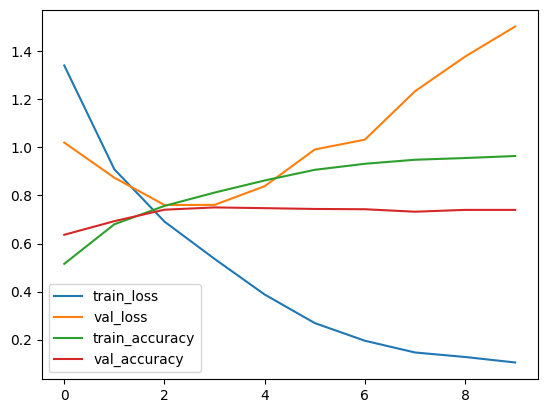

In [ ]:
fit_cnn_model_with_metrics(cnn, x_train, y_train_onehot, x_test, y_test_onehot)

The training loss is 0.1045 and the training accuracy is 0.9644. The validation loss and accuracy on the test set are 1.5038 and 0.7400 respectively.

The train report shows that the model achieved an overall accuracy of 0.98 on the training set. The test report shows that the model achieved an overall accuracy of 0.74 on the test set.

Overfitting occurs when a model performs very well on the training data but not as well on new, unseen data. This can happen when the model is too complex and memorizes the training data instead of learning to generalize to new data.

In this case, it seems that the model is overfitting because it has a high accuracy on the training set but a much lower accuracy on the test set. This suggests that the model is not generalizing well to new data and may be memorizing the training data instead.

### Part 2. Unbalanced Data.
Unbalanced data refers to a situation where the number of samples in each class of a dataset is not equal. This can occur in many real-world scenarios, such as medical diagnosis, fraud detection, or rare event prediction, where one class may be significantly less frequent than the others.

Unbalanced data can have a significant impact on the performance of a classification model. In particular, it can lead to biased predictions, where the model may be more accurate in predicting the majority class but less accurate in predicting the minority class. This is because the model may learn to prioritize the majority class and ignore the minority class, resulting in poor performance on the minority class.

For example, consider a dataset with two classes, A and B, where class A has 90% of the samples and class B has only 10%. If a model is trained on this dataset without accounting for the class imbalance, it may achieve high accuracy by simply predicting class A for all samples, but it will perform poorly on class B.

To address this issue, several techniques can be used to balance the data, such as re-sampling and data augmentation. Another approach is to use cost-sensitive learning, where the model is penalized more for misclassifying the minority class than the majority class. data augmentation is explained later.

Resampling is a technique used to address the issue of imbalanced data in machine learning. It involves modifying the original dataset to create a new dataset with a more balanced class distribution. There are two main types of resampling: oversampling and undersampling.

Oversampling involves increasing the number of samples in the minority class to match the number of samples in the majority class. This can be done by duplicating existing samples in the minority class or by generating new synthetic samples using techniques such as SMOTE (Synthetic Minority Over-sampling Technique).

Undersampling involves reducing the number of samples in the majority class to match the number of samples in the minority class. This can be done by randomly selecting a subset of samples from the majority class or by selecting samples based on a specific criterion, such as distance or density.

Both oversampling and undersampling have their advantages and disadvantages. Oversampling can lead to overfitting and may not work well if the minority class is too small. Undersampling can lead to loss of information and may not work well if the majority class is too small.

In practice, a combination of oversampling and undersampling may be used to create a more balanced dataset. This can be done by first oversampling the minority class and then undersampling the majority class to create a dataset with a more balanced class distribution.

When evaluating the accuracy of a model on an unbalanced dataset, simply looking at the overall accuracy may not be sufficient. This is because the overall accuracy can be misleading if the dataset is heavily imbalanced, as the model may achieve high accuracy by simply predicting the majority class for all samples.

Two common metrics used to evaluate the performance of a model on an unbalanced dataset are the Area Under the Receiver Operating Characteristic Curve (AUC-ROC) and the confusion matrix.

The AUC-ROC is a measure of the model's ability to distinguish between the positive and negative classes. It is calculated by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold values and calculating the area under the resulting curve. The AUC-ROC ranges from 0 to 1, with a value of 0.5 indicating random guessing and a value of 1 indicating perfect classification.

The confusion matrix is a table that summarizes the number of true positives, true negatives, false positives, and false negatives for each class. It can be used to calculate various metrics such as precision, recall, and F1-score for each class. Precision is the proportion of true positives among all predicted positives, recall is the proportion of true positives among all actual positives, and F1-score is the harmonic mean of precision and recall.

In an unbalanced dataset, the confusion matrix can help identify whether the model is biased towards the majority class or is able to correctly predict the minority class. For example, if the model has high precision but low recall for the minority class, it may be biased towards the majority class and may need to be adjusted to improve its performance on the minority class.


To create an unbalanced dataset we will drop 80 percent of airplane and automobiles from the training set.

In [ ]:
airplane_indices = np.where(y_train == 0)[0]
automobile_indices = np.where(y_train == 1)[0]

np.random.seed(0) 
airplane_indices_to_drop = np.random.choice(airplane_indices, int(len(airplane_indices) * 0.8), replace=False)
automobile_indices_to_drop = np.random.choice(automobile_indices, int(len(automobile_indices) * 0.8), replace=False)

indices_to_drop = np.concatenate((airplane_indices_to_drop, automobile_indices_to_drop))

x_train_unbalanced = np.delete(x_train, indices_to_drop, axis=0)
y_train_unbalanced = np.delete(y_train, indices_to_drop, axis=0)
y_train_unbalanced_onehot = np.delete(y_train_onehot, indices_to_drop, axis=0)

In [ ]:
for i in range(10):
    print(f"for class {i} length {np.sum(y_train_unbalanced == i)}")

for class 0 length 1000
for class 1 length 1000
for class 2 length 5000
for class 3 length 5000
for class 4 length 5000
for class 5 length 5000
for class 6 length 5000
for class 7 length 5000
for class 8 length 5000
for class 9 length 5000


313/313 [==============================] - 1s 2ms/step
Train report:
               precision    recall  f1-score   support

           0       0.80      0.13      0.23      1000
           1       0.64      0.53      0.58      1000
           2       0.45      0.69      0.54      5000
           3       0.55      0.36      0.43      5000
           4       0.63      0.52      0.57      5000
           5       0.65      0.46      0.54      5000
           6       0.65      0.79      0.72      5000
           7       0.71      0.75      0.73      5000
           8       0.74      0.89      0.81      5000
           9       0.80      0.81      0.81      5000

    accuracy                           0.64     42000
   macro avg       0.66      0.59      0.60     42000
weighted avg       0.65      0.64      0.63     42000

Test report:
               precision    recall  f1-score   support

           0       0.89      0.09      0.16      1000
           1       0.86      0.46      0.60     

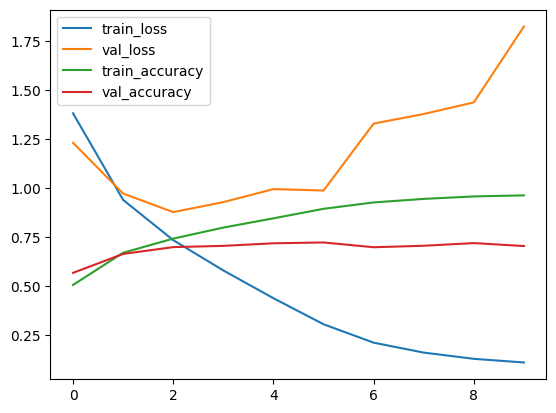

In [ ]:
cnn = create_cnn_model()
fit_cnn_model_with_metrics(cnn, x_train_unbalanced, y_train_unbalanced_onehot, x_test, y_test_onehot)

**Balanced Data**  

Train report:

               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5000
           1       0.98      0.99      0.99      5000
           2       0.98      0.96      0.97      5000
           3       0.95      0.98      0.97      5000
           4       0.98      0.98      0.98      5000
           5       0.98      0.96      0.97      5000
           6       1.00      0.97      0.98      5000
           7       0.98      0.99      0.99      5000
           8       0.97      0.99      0.98      5000
           9       0.99      0.98      0.99      5000

    accuracy:                           0.98     50000

Test report:

               precision    recall  f1-score   support

           0       0.75      0.79      0.77      1000
           1       0.85      0.88      0.86      1000
           2       0.70      0.58      0.64      1000
           3       0.51      0.56      0.53      1000
           4       0.71      0.72      0.71      1000
           5       0.68      0.64      0.66      1000
           6       0.83      0.75      0.79      1000
           7       0.77      0.81      0.79      1000
           8       0.80      0.87      0.83      1000
           9       0.83      0.81      0.82      1000

    accuracy                           0.74     10000

---

**Unbalanced Data**  

Train report:

               precision    recall  f1-score   support

           0       0.98      0.91      0.95      1000
           1       0.96      0.99      0.97      1000
           2       0.99      0.91      0.95      5000
           3       0.96      0.95      0.96      5000
           4       0.94      0.98      0.96      5000
           5       0.97      0.95      0.96      5000
           6       0.94      0.99      0.96      5000
           7       0.97      0.99      0.98      5000
           8       0.97      1.00      0.98      5000
           9       0.99      0.98      0.99      5000

    accuracy                           0.97     42000

Test report:

               precision    recall  f1-score   support

           0       0.88      0.40      0.55      1000
           1       0.89      0.70      0.79      1000
           2       0.69      0.56      0.62      1000
           3       0.56      0.55      0.56      1000
           4       0.66      0.77      0.71      1000
           5       0.64      0.62      0.63      1000
           6       0.70      0.87      0.78      1000
           7       0.77      0.81      0.79      1000
           8       0.64      0.91      0.75      1000
           9       0.77      0.85      0.81      1000

    accuracy                           0.70     10000



---
**Analysis**   

From the results, we can see that the model performs well on the training set with an accuracy of 0.97 before dropping 80 percent of class 0 and 1, and an accuracy of 0.98 after dropping 80 percent class 0 and 1. However, the model's performance drops significantly on the test set, with an accuracy of 0.70 before dropping 80 percent of class 0 and 1, and an accuracy of 0.74 after dropping 80 percent of class 0 and 1. This indicates that the model is overfitting on the training set and is not generalizing well to new data.

Additionally, we can see that the precision, recall, and f1-score vary significantly across different classes. For example, class 0 has a low recall and f1-score on the test set, indicating that the model is not able to correctly identify this class. On the other hand, class 8 has a high precision, recall, and f1-score, indicating that the model is performing well on this class.

Dropping 80% of the samples with labels 0 and 1 from the training data resulted in a decrease in the performance of the model on the test data. The overall test accuracy decreased from 74% to 70%.

In particular, the precision and recall for class 0 (airplane) decreased significantly, from 0.75 and 0.79 to 0.88 and 0.40 respectively. The precision and recall for class 1 (automobile) also decreased, but not as much as for class 0.

This suggests that the model is not generalizing as well to unseen data when trained on a dataset with an imbalance in the distribution of classes.

### Part 3. Data Augmentation 
As  mentioned earlier, data augmentation is a technique used to artificially increase the size of a dataset by creating modified versions of the existing data. This is done by applying various transformations to the original data, such as flipping, rotating, scaling, cropping, or adding noise. The goal of data augmentation is to create new data that is similar to the original data, but different enough to provide additional information to the model during training.

Data augmentation is particularly useful when the original dataset is small or imbalanced, as it can help prevent overfitting and improve the generalization of the model. By creating new data that is similar to the original data, but with slight variations, the model is exposed to a wider range of examples and can learn to recognize patterns more effectively.

Data augmentation is commonly used in computer vision tasks, such as image classification and object detection, but can also be applied to other types of data, such as audio and text. For example, in natural language processing, data augmentation techniques might include replacing words with synonyms, adding or removing punctuation, or changing the order of words in a sentence.

There are many different data augmentation techniques, and the choice of technique will depend on the type of data and the specific task at hand. Some common techniques include:

- Flipping and rotating images
- Scaling and cropping images
- Adding noise to images or audio
- Changing the brightness and contrast of images
- Adding or removing objects from images
- Replacing words with synonyms in text
- Adding or removing punctuation in text
- Changing the order of words in a sentence


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

airplane_indices_unbalanced = np.where(y_train_unbalanced == 0)[0]
automobile_indices_unbalanced = np.where(y_train_unbalanced == 1)[0]
indices = np.concatenate((airplane_indices_unbalanced, automobile_indices_unbalanced))
x_train_airplane_automobile = x_train_unbalanced[indices]
y_train_airplane_automobile = y_train_unbalanced[indices]
# x_train_airplane_automobile = x_train_unbalanced[np.isin(y_train_unbalanced, np.array([0, 1]))]
# y_train_airplane_automobile = y_train_unbalanced[np.isin(y_train_unbalanced, np.array([0, 1]))]
BATCH_SIZE = 32
NUMBER_OF_AUGMENTATIONS = int(2 * (len(x_train) / len(class_names)) - len(x_train_airplane_automobile))

datagen.fit(x_train_airplane_automobile)

x_train_augmented = []
y_train_augmented = []
for x_batch, y_batch in datagen.flow(x_train_airplane_automobile, y_train_airplane_automobile, batch_size=BATCH_SIZE):
    x_train_augmented.append(x_batch)
    y_train_augmented.append(y_batch)
    if len(x_train_augmented) > (NUMBER_OF_AUGMENTATIONS / BATCH_SIZE):
        break

x_train_augmented = np.concatenate(x_train_augmented)
y_train_augmented = np.concatenate(y_train_augmented)

x_train_augmented = np.concatenate((x_train_unbalanced, x_train_augmented))
y_train_augmented = np.concatenate((y_train_unbalanced, y_train_augmented))
y_train_augmented_onehot = tf.keras.utils.to_categorical(y_train_augmented, num_classes=10)
y_test_augmented_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
for i in range(10):
    print(f"for class {i} length {np.sum(y_train_augmented == i)}")

for class 0 length 4992
for class 1 length 4992
for class 2 length 5000
for class 3 length 5000
for class 4 length 5000
for class 5 length 5000
for class 6 length 5000
for class 7 length 5000
for class 8 length 5000
for class 9 length 5000


313/313 [==============================] - 1s 2ms/step
Train report:
               precision    recall  f1-score   support

           0       0.54      0.87      0.67      4994
           1       0.75      0.79      0.77      4990
           2       0.58      0.46      0.51      5000
           3       0.50      0.39      0.44      5000
           4       0.52      0.62      0.57      5000
           5       0.61      0.52      0.56      5000
           6       0.73      0.72      0.72      5000
           7       0.70      0.73      0.71      5000
           8       0.81      0.61      0.70      5000
           9       0.81      0.77      0.79      5000

    accuracy                           0.65     49984
   macro avg       0.66      0.65      0.64     49984
weighted avg       0.66      0.65      0.64     49984

Test report:
               precision    recall  f1-score   support

           0       0.53      0.80      0.64      1000
           1       0.71      0.73      0.72     

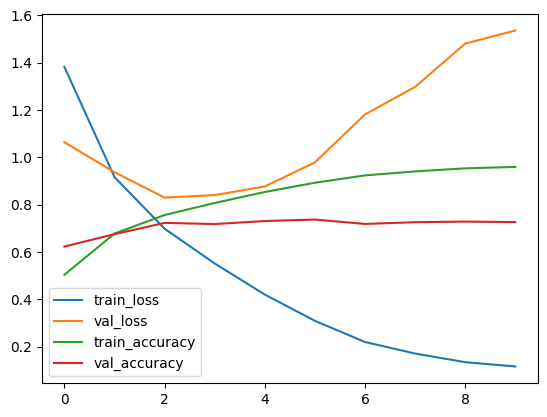

In [ ]:
cnn = create_cnn_model()
fit_cnn_model_with_metrics(cnn, x_train_augmented, y_train_augmented_onehot, x_test, y_test_onehot)

**Augmented Data**  

Train report:

               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4994
           1       0.99      0.99      0.99      4990
           2       0.98      0.95      0.97      5000
           3       0.97      0.96      0.97      5000
           4       0.96      0.98      0.97      5000
           5       0.98      0.97      0.97      5000
           6       0.97      0.99      0.98      5000
           7       0.97      1.00      0.98      5000
           8       0.99      0.98      0.99      5000
           9       0.98      1.00      0.99      5000

    accuracy                           0.98     49984

Test report:

               precision    recall  f1-score   support

           0       0.80      0.63      0.70      1000
           1       0.88      0.74      0.81      1000
           2       0.66      0.61      0.64      1000
           3       0.57      0.53      0.55      1000
           4       0.66      0.75      0.70      1000
           5       0.66      0.63      0.64      1000
           6       0.76      0.83      0.79      1000
           7       0.74      0.82      0.78      1000
           8       0.82      0.82      0.82      1000
           9       0.72      0.89      0.80      1000

    accuracy                           0.73     10000

---

**Unbalanced Data**  

Train report:

               precision    recall  f1-score   support

           0       0.98      0.91      0.95      1000
           1       0.96      0.99      0.97      1000
           2       0.99      0.91      0.95      5000
           3       0.96      0.95      0.96      5000
           4       0.94      0.98      0.96      5000
           5       0.97      0.95      0.96      5000
           6       0.94      0.99      0.96      5000
           7       0.97      0.99      0.98      5000
           8       0.97      1.00      0.98      5000
           9       0.99      0.98      0.99      5000

    accuracy                           0.97     42000

Test report:

               precision    recall  f1-score   support

           0       0.88      0.40      0.55      1000
           1       0.89      0.70      0.79      1000
           2       0.69      0.56      0.62      1000
           3       0.56      0.55      0.56      1000
           4       0.66      0.77      0.71      1000
           5       0.64      0.62      0.63      1000
           6       0.70      0.87      0.78      1000
           7       0.77      0.81      0.79      1000
           8       0.64      0.91      0.75      1000
           9       0.77      0.85      0.81      1000

    accuracy                           0.70     10000


---
**Analysis**

1. **Training performance**: The model trained on augmented data achieved an accuracy of 0.98, while the model trained on unbalanced data achieved an accuracy of 0.97. This indicates that the data augmentation process slightly improved the model's performance on the training set.

2. **Testing performance**: The model trained on augmented data achieved an accuracy of 0.73 on the test set, while the model trained on unbalanced data achieved an accuracy of 0.70. This shows that the data augmentation process improved the model's generalization to unseen data, resulting in a 3% increase in test accuracy.

3. **Class-wise performance**: The f1-scores for individual classes in the test set show that the model trained on augmented data generally performs better across all classes compared to the model trained on unbalanced data. This suggests that the data augmentation process helped the model to better learn the underlying patterns in the data and improved its ability to classify instances from different classes.  

---

**Closer examination of the class-wise performance for classes 0 and 1:**

**Unbalanced Data**

Class 0:
- Precision: 0.88
- Recall: 0.40
- F1-score: 0.55

Class 1:
- Precision: 0.89
- Recall: 0.70
- F1-score: 0.79

**Augmented Data**

Class 0:
- Precision: 0.80
- Recall: 0.63
- F1-score: 0.70

Class 1:
- Precision: 0.88
- Recall: 0.74
- F1-score: 0.81  

Comparing the performance metrics for classes 0 and 1 in both datasets:

- **Precision**: The precision for class 0 decreased from 0.88 to 0.80 after augmentation, while the precision for class 1 remained almost the same (0.89 to 0.88). This indicates that the model trained on augmented data has a slightly higher rate of false positives for class 0, but the precision for class 1 is mostly unaffected.

- **Recall**: The recall for class 0 increased significantly from 0.40 to 0.63 after augmentation, and the recall for class 1 also increased from 0.70 to 0.74. This shows that the model trained on augmented data is better at identifying true positives for both classes 0 and 1, which were underrepresented in the original dataset.

- **F1-score**: As previously mentioned, the f1-scores for class 0 and 1 improved after augmentation (from 0.55 to 0.70 for class 0, and from 0.79 to 0.81 for class 1). This indicates that the overall classification performance for these classes has improved due to the augmentation process.

In conclusion, the data augmentation process has led to a significant improvement in recall for both underrepresented classes (0 and 1), while the precision for class 0 decreased slightly and the precision for class 1 remained mostly unchanged. The overall classification performance, as measured by the f1-score, has improved for both classes. This suggests that the augmentation process has been beneficial in addressing the class imbalance and improving the model's performance for the underrepresented classes.


### Part 4. Regularization
First we need to explain overfitting. Overfitting is a common problem in machine learning where a model is trained too well on the training data and performs poorly on new, unseen data. 

Regularization is a technique used in machine learning to prevent overfitting and improve the generalization performance of a model. Overfitting occurs when a model is too complex and starts to memorize the training data instead of learning the underlying patterns. This can lead to poor performance on new, unseen data.

Regularization works by adding a penalty term to the loss function that the model is trying to minimize. This penalty term encourages the model to have smaller weights or simpler representations, which can help prevent overfitting.

There are several common ways to implement regularization in machine learning:

1. `L1 Regularization`: This adds a penalty term to the loss function that is proportional to the absolute value of the weights. L1 regularization encourages the model to have sparse weights, meaning that many of the weights are set to zero. This can help simplify the model and prevent overfitting.

2. `L2 Regularization`: This adds a penalty term to the loss function that is proportional to the square of the weights. L2 regularization encourages the model to have small weights, which can also help prevent overfitting. L2 regularization is also known as weight decay.

3. `Dropout`: It works by randomly dropping out (i.e., setting to zero) some of the neurons during training. Dropout encourages the network to learn redundant representations of the data, which can help prevent overfitting.

4. `Early Stopping`: This is a technique used to prevent overfitting by stopping the training process early, before the model has a chance to memorize the training data. Early stopping involves monitoring the performance of the model on a validation set during training and stopping the training process when the performance on the validation set starts to degrade.

5. `Data Augmentation`: In this technique we increase the size of the training set. Data augmentation involves applying random transformations to the training data, such as rotating, scaling, or flipping the images. This can help the model learn more robust representations of the data and prevent overfitting.

6. `Batch Normalization`: The idea behind batch normalization is to normalize the inputs to each layer of the network, so that the distribution of inputs is more stable and consistent across the layers. This helps to prevent the "internal covariate shift" problem, where the distribution of inputs to each layer changes during training, making it harder for the network to learn.

---

We are gonna use `Batch normalization` and `Dropout` to help train our model. Here are more detailed about these two methods:

***Dropout:***  
Dropout is a regularization technique used in neural networks to prevent overfitting. Overfitting occurs when a model is too complex and starts to memorize the training data instead of learning the underlying patterns. This can lead to poor generalization performance on new, unseen data.

During training, dropout randomly drops out (i.e., sets to zero) some of the neurons in the neural network. This means that the network is forced to learn redundant representations of the data, which can help prevent overfitting. Dropout is like training multiple neural networks with different architectures and then averaging their outputs, which can improve the generalization performance of the network.

The dropout rate is a hyperparameter that determines the probability of dropping out each neuron. A common value for the dropout rate is 0.5, which means that each neuron has a 50% chance of being dropped out during training.

Dropout can be applied to different types of layers in a neural network, including fully connected layers, convolutional layers, and recurrent layers. It is important to note that dropout should only be applied during training and not during inference, as it can lead to inconsistent results.

***Batch normalization:***  
Batch normalization is a technique used in neural networks to improve the training process and prevent overfitting. It works by normalizing the inputs to each layer in the network, which can help reduce the internal covariate shift.

The internal covariate shift refers to the change in the distribution of the inputs to each layer during training. This can make it difficult for the network to learn the underlying patterns in the data, as the distribution of the inputs keeps changing. Batch normalization helps to address this issue by normalizing the inputs to each layer, which can help reduce the internal covariate shift.

During training, batch normalization computes the mean and standard deviation of the inputs to each layer over a mini-batch of training examples. It then normalizes the inputs using these statistics, which can help reduce the internal covariate shift. Batch normalization also includes learnable parameters (gamma and beta) that can be used to scale and shift the normalized inputs, which can help the network learn more complex representations.

Batch normalization can be applied to different types of layers in a neural network, including fully connected layers, convolutional layers, and recurrent layers. It is typically applied after the activation function in each layer.


In [8]:
def create_cnn_model_with_regularization(
    activation_for_conv: str = "relu",
    max_pooling_size: tuple[int, int] = (2, 2),
    dropout_rate: float = 0.5,
):
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
    cnn.add(Activation(activation_for_conv))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (3, 3)))
    cnn.add(Activation(activation_for_conv))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=max_pooling_size))
    cnn.add(Dropout(dropout_rate))

    cnn.add(Conv2D(64, (3, 3), padding="same"))
    cnn.add(Activation(activation_for_conv))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(64, (3, 3)))
    cnn.add(Activation(activation_for_conv))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=max_pooling_size))
    cnn.add(Dropout(dropout_rate))

    cnn.add(Flatten())
    cnn.add(Dense(512))
    cnn.add(Activation(activation_for_conv))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(dropout_rate))
    cnn.add(Dense(10))
    cnn.add(Activation("softmax"))
    cnn.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )

    return cnn

313/313 [==============================] - 1s 2ms/step
Train report:
               precision    recall  f1-score   support

           0       0.75      0.52      0.61      5000
           1       0.72      0.75      0.73      5000
           2       0.56      0.40      0.47      5000
           3       0.38      0.59      0.46      5000
           4       0.59      0.47      0.52      5000
           5       0.56      0.39      0.46      5000
           6       0.57      0.80      0.67      5000
           7       0.69      0.63      0.66      5000
           8       0.70      0.73      0.71      5000
           9       0.67      0.74      0.71      5000

    accuracy                           0.60     50000
   macro avg       0.62      0.60      0.60     50000
weighted avg       0.62      0.60      0.60     50000

Test report:
               precision    recall  f1-score   support

           0       0.75      0.53      0.62      1000
           1       0.72      0.73      0.73     

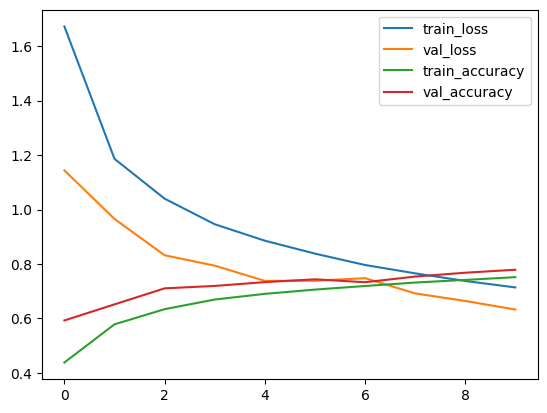

In [10]:
cnn_regularized = create_cnn_model_with_regularization()
fit_cnn_model_with_metrics(cnn_regularized, x_train, y_train_onehot, x_test, y_test_onehot)

**Without Regularization**  

Train report:

               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5000
           1       0.98      0.99      0.99      5000
           2       0.98      0.96      0.97      5000
           3       0.95      0.98      0.97      5000
           4       0.98      0.98      0.98      5000
           5       0.98      0.96      0.97      5000
           6       1.00      0.97      0.98      5000
           7       0.98      0.99      0.99      5000
           8       0.97      0.99      0.98      5000
           9       0.99      0.98      0.99      5000

    accuracy:                           0.98     50000

Test report:

               precision    recall  f1-score   support

           0       0.75      0.79      0.77      1000
           1       0.85      0.88      0.86      1000
           2       0.70      0.58      0.64      1000
           3       0.51      0.56      0.53      1000
           4       0.71      0.72      0.71      1000
           5       0.68      0.64      0.66      1000
           6       0.83      0.75      0.79      1000
           7       0.77      0.81      0.79      1000
           8       0.80      0.87      0.83      1000
           9       0.83      0.81      0.82      1000

    accuracy                           0.74     10000

---

**With Regularization**  

Train report:

               precision    recall  f1-score   support

           0       0.92      0.76      0.83      5000
           1       0.94      0.94      0.94      5000
           2       0.73      0.74      0.74      5000
           3       0.74      0.57      0.65      5000
           4       0.73      0.85      0.79      5000
           5       0.71      0.76      0.73      5000
           6       0.84      0.89      0.86      5000
           7       0.90      0.84      0.87      5000
           8       0.85      0.95      0.90      5000
           9       0.90      0.92      0.91      5000

    accuracy                           0.82     50000

Test report:

               precision    recall  f1-score   support

           0       0.87      0.73      0.80      1000
           1       0.89      0.91      0.90      1000
           2       0.67      0.66      0.66      1000
           3       0.66      0.51      0.57      1000
           4       0.69      0.81      0.75      1000
           5       0.67      0.72      0.70      1000
           6       0.78      0.86      0.81      1000
           7       0.87      0.80      0.84      1000
           8       0.84      0.91      0.87      1000
           9       0.87      0.88      0.87      1000

    accuracy                           0.78     10000



---
**Analysis**  
1. Training accuracy: The model without regularization achieved a higher training accuracy of 98%, while the model with regularization had a training accuracy of 82%. This indicates that the model without regularization has likely overfit the training data, as it has learned the training data too well.

2. Test accuracy: The model with regularization achieved a higher test accuracy of 78%, compared to the model without regularization, which had a test accuracy of 74%. This suggests that the model with regularization generalizes better to unseen data.

3. Precision, recall, and F1-score: The model without regularization had higher precision, recall, and F1-scores for the training set, but lower scores for the test set. On the other hand, the model with regularization had lower scores for the training set but higher scores for the test set. This further supports the idea that the model with regularization generalizes better to new data.

In conclusion, adding regularization to model has helped to reduce overfitting, leading to better generalization on the test set. Although the training accuracy is lower for the model with regularization, it performs better on unseen data, which is more important in real-world applications. Regularization has helped to create a more robust model that is less likely to be affected by noise or small variations in the input data.
